# Proyecto 2 Ironhack. 
Analisis de Lista de Reproduccion. Generacion de una lista de reproduccion nueva

In [13]:
import base64
import requests
import datetime
from urllib.parse import urlencode
import pandas as pd
import matplotlib
%matplotlib inline

# Documentacion para las Playlist: 
# https://developer.spotify.com/documentation/web-api/reference/playlists/get-a-list-of-current-users-playlists/
# Documentacion Obtencion de info de las listas de reproduccion:
# https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/
# Documentacion para la info de las canciones:
# https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/
# Referencia para el login en la API de Spotify:
# https://www.youtube.com/watch?v=xdq6Gz33khQ&t=4594s&ab_channel=CodingEntrepreneurs
# las funciones agregadas son tomando ideas de aquí.

# Tres Llamadas Get para descargar la data 

## 1. Coneccion con la API de Spotify

In [14]:
# Llaves de acceso para conectarnos a la API de Spotify
client_id = '8e5f91c2fc27453eb255a039b42bcb70'
client_secret = '09645aff5c8849f2baab977e4cfd1017'
user_id = '1279741536'

In [15]:
# Generamos esta classe que nos funcionará para que de manera automatica se genere toda la solicitud de acceso a la API

class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    client_id = None
    client_secret = None
    access_token_did_expire = True
    token_url = 'https://accounts.spotify.com/api/token'
    
    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args,**kwargs)
        self.client_id = client_id
        self.client_secret = client_secret
    
    # Aqui se crean las credenciales en base 64 para poder acceder a la API
    def get_client_credentials(self):
        """ returns a base64 encoded string """
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise Exception("You must set client_id and client_secret")
            
        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())        
        return client_creds_b64.decode()
    
    # Aqui estamos generando los headers de acceso
    def get_token_headers(self):
        client_creds_b64 = self.get_client_credentials()
        
        return {
            "Authorization":f"Basic {client_creds_b64}"
        }
    
    def get_token_data(self):
        return {
            "grant_type":"client_credentials"
        }
    
    # Aqui nos autentificamos y obtenemos el token de acceso
    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()
        
        r = requests.post(token_url, data = token_data, headers = token_headers)

        if r.status_code not in range(200,299):
            raise Exceptiontion('Could not authenticate client')
        
            
        data = r.json()
        now = datetime.datetime.now()
        acces_token = data['access_token']
        expires_in = data['expires_in'] #seconds
        expires = now + datetime.timedelta(seconds = expires_in)
        self.access_token = acces_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now
        return True
    
    # Extraemos el token de acceso
    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token()
        return token
    
    # Aqui son los headers de para las busquedas
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization":f"Bearer {access_token}"
        }
        return headers
        
    # busqueda de listas de reproduccion
    def get_user_playlist(self,u_id):
        endpoint = f'https://api.spotify.com/v1/users/{user_id}/playlists'
        headers = self.get_resource_header()
        r = requests.get(endpoint,headers=headers)
        if r.status_code not in range(200,299):
            return {}
        return r.json()
    
    # Busqueda de las canciones por playlist: nombre, 
    def get_song_playlist(self,playlist_id):
        endpoint = f'https://api.spotify.com/v1/playlists/{playlist_id}/tracks'
        headers = self.get_resource_header()
        r = requests.get(endpoint,headers=headers)
        if r.status_code not in range(200,299):
            return {}
        return r.json()
    
    # Busqueda de las caracteristicas de las canciones
    def get_audio_features(self,song_id):
        endpoint = f'https://api.spotify.com/v1/audio-features/{song_id}'
        headers = self.get_resource_header()
        r = requests.get(endpoint,headers=headers)
        if r.status_code not in range(200,299):
            return {}
        return r.json()

In [16]:
# Llamamos a la funcion y le asignamos nuestros client ID y Client Secret
spotify = SpotifyAPI(client_id,client_secret)

In [17]:
# Nos indica si fue realizada la coneccion con la API
spotify.perform_auth()

True

In [18]:
# Obtenemos el access_token que nos servirá para las consultas nescesarias. Por eso lo guardamos en una variable y que sea mas
# sencillo llamarlo posteriormente.
access_token = spotify.access_token
access_token

'BQC5PmhhWnvRPeGHINH4jvZgsCnhjwN0MA4ULsGiFGy959R_qfadgnjrJs2af_ujAE2C6H5UEeuHoZiYB0E'

## 2. Busqueda y descarga de la informacion de las listas de reproduccion

Acousticness: una medida de confianza de 0.0 a 1.0 de si la pista es acústica. 1.0 representa una alta confianza 
en que la pista es acústica.

Danceability: la capacidad de baile describe qué tan adecuada es una pista para bailar en función de una combinación 
de elementos musicales que incluyen el tempo, la estabilidad del ritmo, la fuerza del ritmo y la regularidad general. 
Un valor de 0.0 es menos bailable y 1.0 es más bailable.

Energy: La energía es una medida de 0.0 a 1.0 y representa una medida perceptiva de intensidad y actividad. 
Por lo general, las pistas enérgicas se sienten rápidas, ruidosas y ruidosas. Por ejemplo, el death metal 
tiene mucha energía, mientras que un preludio de Bach tiene una puntuación baja en la escala. 
Las características de percepción que contribuyen a este atributo incluyen rango dinámico, 
volumen percibido, timbre, frecuencia de inicio y entropía general.

Instrumentalness: predice si una pista no contiene voces. Los sonidos "Ooh" y "aah" se tratan como instrumentales 
en este contexto. Las pistas de rap o de palabra hablada son claramente "vocales". Cuanto más cercano esté el valor 
de instrumentalidad a 1.0, mayor será la probabilidad de que la pista no contenga contenido vocal. 
Los valores superiores a 0,5 están destinados a representar pistas instrumentales, pero la confianza es mayor a medida 
que el valor se acerca a 1,0.

Liveness: detecta la presencia de una audiencia en la grabación. Los valores de vivacidad más altos representan una mayor
probabilidad de que la pista se haya interpretado en vivo. 
Un valor por encima de 0,8 proporciona una gran probabilidad de que la pista esté activa.

Loudness: la sonoridad general de una pista en decibelios (dB). Los valores de sonoridad se promedian en toda la pista y 
son útiles para comparar la sonoridad relativa de las pistas. La sonoridad es la cualidad de un sonido que es el 
principal correlato psicológico de la fuerza física (amplitud). Los valores típicos oscilan entre -60 y 0 db.

Speechiness: el habla detecta la presencia de palabras habladas en una pista. Cuanto más exclusivamente parecida 
a un discurso sea la grabación (por ejemplo, programa de entrevistas, audiolibro, poesía), más cercano a 1.0 será el 
valor del atributo. Los valores superiores a 0,66 describen pistas que probablemente estén compuestas en su totalidad 
por palabras habladas. Los valores entre 0,33 y 0,66 describen pistas que pueden contener tanto música como habla, 
ya sea en secciones o en capas, incluidos casos como la música rap. 
Los valores por debajo de 0,33 probablemente representen música y otras pistas que no se parecen al habla.

Valence: Medida de 0.0 a 1.0 que describe la positividad musical que transmite una pista. Las pistas con valencia alta 
suenan más positivas (por ejemplo, feliz, alegre, eufórico), mientras que las pistas con valencia baja suenan más 
negativas (por ejemplo, triste, deprimido, enojado).

Tempo: el tempo total estimado de una pista en tiempos por minuto (BPM). En terminología musical, 
el tempo es la velocidad o ritmo de una pieza determinada y se deriva directamente de la duración media del tiempo.

In [19]:
# Funcion General para obtener info de las listas de reproduccion de un usuario, las canciones de dicha lista y
# las caracteristicas de dichas canciones. 
def playlist_data(user_id):
    # Obtenemos las listas de reproduccion en mi usuario
    playlist = spotify.get_user_playlist(user_id)
    columns = ['name','id','tracks']
    #df_playlist = pd.DataFrame(playlist['items'],columns=columns)
    
    # Generamos una lista con los ID de las listas de reproduccion
    id_playlist = [playlist['items'][i]['id'] for i in range(len(playlist['items']))]
    

    # Analizamos una lista de reproduccion mediante su ID
    # Obtenemos la info de las canciones en la lista de reproduccion (ID, Nombre, Album y Artista) y lo colocamos todo en un solo df
    # Se eliminan aquellas canciones que tengan un "nulo" en ID, ya que no nos permitirán extraer la info futura
    canciones = []
    for a in id_playlist:
        lista_1 = spotify.get_song_playlist(a)
        for i in range(len(lista_1['items'])):
            id_cancion = lista_1['items'][i]['track']['id']
            nombre_cancion = lista_1['items'][i]['track']['name']
            album =lista_1['items'][i]['track']['album']['name']
            artista = lista_1['items'][i]['track']['artists'][0]['name']
            
            # hacemos una lista de las canciones
            canciones.append([id_cancion,nombre_cancion,album,artista])
    
    # Creamos un df con la info de las canciones
    df = pd.DataFrame(canciones,columns =['id','nombre','album','artista'])
    # Eliminamos los NA del df
    df = df.dropna(axis=0)
   
    song_features = []
    # Obtenemos el listado de id de las canciones para poder buscar su info
    canciones_id =[canciones[i][0] for i in range(len(canciones))]
    
    # Buscamos la info de cada cancion
    for i in canciones_id:
        features = spotify.get_audio_features(i)
        # Caracteristicas de las canciones
        danceability = features['danceability'] if 'danceability' in features else None 
        energy =features['energy'] if 'energy' in features else None 
        loudness=features['loudness'] if 'loudness' in features else None 
        speechiness= features['speechiness'] if 'speechiness' in features else None 
        acousticness=features['acousticness'] if 'acousticness' in features else None 
        instrumentalness=features['instrumentalness'] if 'instrumentalness' in features else None 
        liveness=features['liveness'] if 'liveness' in features else None 
        valence=features['valence'] if 'valence' in features else None 
        tempo=features['tempo'] if 'tempo' in features else None 
        id_ = features['id'] if 'id' in features else None 
        
        # Creamos una lista con la info por cada cancion
        song_features.append([danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id_])
    
    # Creamos el df de las caracteristicas de las canciones
    columns =['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','id']
    df_features = pd.DataFrame(song_features,columns = columns)
    df_features = df_features.dropna(axis=0)

    # Unimos el df de las caracteristicas de las canciones con el de la info de las canciones, mediante el ID de la canción
    data = pd.merge(df,df_features,on='id')
    return data

In [20]:
#data = playlist_data(user_id)
#data.set_index(data['id'])
#data

In [21]:
# Función modificada para solo obtener la lista de reproduccion que corresponda con una seleccion, en este caso que sea mia y de mi 
# pareja para analizar los gustos musicales de cada quien. 
# se agrega funcion logica para identificarlas por el nombre
# Al final, se debe de obtener el df de cada quien. 

# Generamos una lista con los ID de las listas de reproduccion
def identificador_playlist(user_id):
    playlist = spotify.get_user_playlist(user_id)

    other_playlist= []

    for i in range(len(playlist['items'])):
        if playlist['items'][i]['name'].startswith('Brendiux'):
            brendiux_playlist = playlist['items'][i]['id']
        elif playlist['items'][i]['name'].startswith('Rikrdinii'):
            rikrdinii_playlist = playlist['items'][i]['id']
        else:
            other_playlist.append(playlist['items'][i]['id'])
    
    r = input('¿Que Lista de reproduccion desea Analizar?: 1. Ricardo / 2.Brenda / 3. Otras Listas.  ')
    if r.lower() == 'ricardo':
        return rikrdinii_playlist
    elif r.lower() == 'brenda':
        return brendiux_playlist
    #elif r.lower() == 'otras' or r.lower() == 'otras listas':
    else:
        return other_playlist

## 3. Analisis de las listas de reproduccion

In [22]:
# Analizamos una lista de reproduccion mediante su ID
# Obtenemos la info de las canciones en la lista de reproduccion (ID, Nombre, Album y Artista) y lo colocamos todo en un solo df
# Se eliminan aquellas canciones que tengan un "nulo" en ID, ya que no nos permitirán extraer la info futura
def playlist_analysis(id_playlist):
    
    canciones = []
    
    try:
        for a in id_playlist:
            lista_1 = spotify.get_song_playlist(a)
            for i in range(len(lista_1['items'])):
                id_cancion = lista_1['items'][i]['track']['id']
                nombre_cancion = lista_1['items'][i]['track']['name']
                album =lista_1['items'][i]['track']['album']['name']
                artista = lista_1['items'][i]['track']['artists'][0]['name']

                # hacemos una lista de las canciones
                canciones.append([id_cancion,nombre_cancion,album,artista])
    except:
        lista_1 = spotify.get_song_playlist(id_playlist)
        for i in range(len(lista_1['items'])):
            id_cancion = lista_1['items'][i]['track']['id']
            nombre_cancion = lista_1['items'][i]['track']['name']
            album =lista_1['items'][i]['track']['album']['name']
            artista = lista_1['items'][i]['track']['artists'][0]['name']

            # hacemos una lista de las canciones
            canciones.append([id_cancion,nombre_cancion,album,artista])

    # Creamos un df con la info de las canciones
    df = pd.DataFrame(canciones,columns =['id','nombre','album','artista'])
    # Eliminamos los NA del df
    df = df.dropna(axis=0)
   
    song_features = []
    # Obtenemos el listado de id de las canciones para poder buscar su info
    canciones_id =[canciones[i][0] for i in range(len(canciones))]
    
    # Buscamos la info de cada cancion
    for i in canciones_id:
        features = spotify.get_audio_features(i)
        # Caracteristicas de las canciones
        danceability = features['danceability'] if 'danceability' in features else None 
        energy =features['energy'] if 'energy' in features else None 
        loudness=features['loudness'] if 'loudness' in features else None 
        speechiness= features['speechiness'] if 'speechiness' in features else None 
        acousticness=features['acousticness'] if 'acousticness' in features else None 
        instrumentalness=features['instrumentalness'] if 'instrumentalness' in features else None 
        liveness=features['liveness'] if 'liveness' in features else None 
        valence=features['valence'] if 'valence' in features else None 
        tempo=features['tempo'] if 'tempo' in features else None 
        id_ = features['id'] if 'id' in features else None 
        
        # Creamos una lista con la info por cada cancion
        song_features.append([danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id_])
    
    # Creamos el df de las caracteristicas de las canciones
    columns =['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','id']
    df_features = pd.DataFrame(song_features,columns = columns)
    df_features = df_features.dropna(axis=0)

    # Unimos el df de las caracteristicas de las canciones con el de la info de las canciones, mediante el ID de la canción
    data = pd.merge(df,df_features,on='id')
    return data

¿Que Lista de reproduccion desea Analizar?: 1. Ricardo / 2.Brenda / 3. Otras Listas.  ricardo


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f02335a8d90>,
      dtype=object)

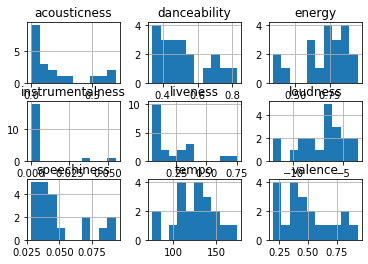

In [23]:
playlist_analysis(identificador_playlist(user_id)).hist()

## 4. Generacion de las nuevas listas de reproduccion con canciones que tengan caracteristicas similares a las de las listas de reproduccion generadas.

In [12]:
# un metodo post para subir la lista de reproduccion

## 5. BONUS: Scrapear lista de reproduccion de wikipedia de Luke Cage y generar la lista de reproduccion pertinente